Notes:
    
14Apr15: *Changed Model's 'test' method to take the type of report as input. We should be using AUC most of the time (that is how the comp is scored) but might be useful to use classificaition report sometimes.
*Classes start with caps, functions/methods in camel case

TODO:
*Add getter to "model" for classification results

*Fix init (Mike to do) to make pythonic. Also have it accept params so our classes can be used for grid searching WITHOUT breaking existing classes

*Make GridSearchCV work

*Visualize all numeric data

*Normalize data?

In [1]:
'''
This cell's function:
Import all libraries that will be needed throughout document
'''
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import json
from pprint import pprint
import datetime
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score


# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



In [2]:
class Data_handler():
    
    if __name__ == "__main__":
        dfTrain_full = pd.DataFrame()
        dfTest = pd.DataFrame()
        dfTrain = pd.DataFrame()
        dfDev = pd.DataFrame()
        trainColumnNames = []
        testColumnNames = []
    
    def initialize_data(self,train_json, test_json, prop_train):
        #Load in data as panda dataframes
        with open(train_json,'r') as fp: 
            json_data = json.load(fp)
        self.dfTrain_full = pd.io.json.json_normalize(json_data)

        with open(test_json,'r') as fp: 
            json_data = json.load(fp)
        self.dfTest = pd.io.json.json_normalize(json_data)

        # Set np seed
        np.random.seed(0)

        #Shuffle train data and split into train and dev
        self.dfTrain_full.reindex(np.random.permutation(self.dfTrain_full.index)) #shuffle
        nTrain_full = self.dfTrain_full.shape[0]
        self.dfTrain = self.dfTrain_full[:int(nTrain_full*prop_train)]
        self.dfDev = self.dfTrain_full[int(nTrain_full*prop_train):]
        
        #Save number of observations in train and dev
        nTrain = self.dfTrain.shape[0]
        nDev = self.dfDev.shape[0]

        #Save column names for reference
        self.trainColumnNames = self.dfTrain.columns.tolist()
        self.testColumnNames = self.dfTest.columns.tolist() #Note test features is only a subset!
        
        return nTrain_full, nTrain, nDev ################# WHY DOES THIS GET RETURNED? WHAT IS IT USED FOR?
    
    def getTrainFull(self):
        return self.dfTrain_full   
    def getTest(self):
        return self.dfTest   
    def getTrain(self):
        return self.dfTrain   
    def getDev(self):
        return self.dfDev    
    def getTrainColumnNames(self):
        return self.trainColumnNames   
    def getTestColumnNames(self):
        return self.testColumnNames
    
# Load in our data to master_data. Proportion in train vs dev is set here. Changing it will take effect throughout everything else in the script (the magic of classes!)
master_data = Data_handler()
master_data.initialize_data('train.json', 'test.json',.75)


(4040, 3030, 1010)

In [3]:
class FeatureEngineer():
    '''
    Module that contains some of our feature engineering methods. 
    Does not contain instance variables!
    Outputs np arrays or dataframes as needed
    '''
    def separateTimestamp(self,df):
        '''
        separates time stamp (UTC) into month, day, hour. If user's local time is of interest, 
        use the non UTC data
        input: any dataFrame containing the timestamp data
        '''

        timeStamps = df['unix_timestamp_of_request_utc'].values #numpy array of timestamps
        timeStampsSeparate = [] #init new

        # Loop over timestamps
        for ts in timeStamps:
            # Pull out relevant time info
            d = datetime.datetime.fromtimestamp(ts)
            month = d.strftime("%m")
            day_of_month = d.strftime("%d")
            hour = d.strftime("%H")
            # Append to results
            timeStampsSeparate.append([int(month),int(day_of_month),int(hour)])
        
        #manually create labels
        labels = ['month','day_of_month','hour']
        #convert from python list to ndarray
        return np.asarray(timeStampsSeparate), labels

    def newTimeInfo(self,df):
        '''
        New expressions of time e.g day of week
        '''
        
        timeStamps = df['unix_timestamp_of_request'].values #LOCAL time
        timeStampsSeparate = [] #init new

        # Loop over timestamps
        for ts in timeStamps:
            # Pull out relevant time info
            d = datetime.datetime.fromtimestamp(ts)
            day_of_week = d.isoweekday()
            local_time =d.strftime("%H")
            # Append to results
            timeStampsSeparate.append([int(day_of_week),int(local_time)])
        
        #convert from python list to ndarray
        return np.asarray(timeStampsSeparate)
        
    def selectedNumericFeatures(self,df):
        '''
        Some hand picked numeric features that seem to work well in logistic regression
        Dependency: separateTimestamp
        '''
        colNames = [master_data.getTestColumnNames()[i] for i in [5,7,8,9]] #hand picked to be plausible, not optimal 
        #numeric data
        dfNum = df[colNames].values
        #convert time stamp into nice format
        dfTime, labelsTime = self.separateTimestamp(df)
        #merge
        combinedData = np.column_stack((dfNum,dfTime))
        combinedLabels = colNames+labelsTime
        return combinedData, combinedLabels
    
    def allNumericFeatures(self,df):
        '''
        All of the numeric features that come standard.
        Dependency: separateTimestamp
        '''
        colNames = [master_data.getTestColumnNames()[i] for i in [4,5,6,7,8,9,10,12,13]] 
        #numeric data
        dfNum = df[colNames].values
        #convert time stamp into nice format
        dfTime, labelsTime = self.separateTimestamp(df)
        #merge
        combinedData = np.column_stack((dfNum,dfTime))
        combinedLabels = colNames+labelsTime
        return combinedData, combinedLabels
    
    def simpleNewFeatures(self,df):
        '''
        Basic self explanatory features.
        Input: whole df
        '''
        
        #From text
        title_length = [len(t) for t in df['request_title'].values]
        req_length = [len(t) for t in df['request_text_edit_aware'].values]
        avg_word_length = [float(len(t))/len(t.split(' ')) for t in df['request_text_edit_aware'].values] #complexity of lang
        title_caps_norm = [sum(1 for c in t if c.isupper())/(float(len(t))+1) for t in df['request_title'].values]
        req_caps_norm = [sum(1 for c in t if c.isupper())/(float(len(t))+1) for t in df['request_text_edit_aware'].values]
        #num_all_caps_words
        #num_repeated_words #perhaps normalize and/or remove shorter words
        
        ###special chars in text
        num_numbers_norm = [sum(1 for c in t if c.isdigit())/(float(len(t))+1) for t in df['request_text_edit_aware'].values]
        num_currency_chars_norm = [sum(1 for c in t if c in '$')/(float(len(t))+1) for t in df['request_text_edit_aware'].values]
        num_exclamation_norm = [sum(1 for c in t if c in '!')/(float(len(t))+1) for t in df['request_text_edit_aware'].values]
        num_commas_norm = [sum(1 for c in t if c in ',')/(float(len(t))+1) for t in df['request_text_edit_aware'].values]
        
        ###language
        #grammar_errors #normalized for request length
        #spelling_errors #normalized for request length
        
        f = np.asarray([title_length,
                          req_length,
                          avg_word_length,
                          title_caps_norm,
                          req_caps_norm,
                          num_numbers_norm,
                          num_currency_chars_norm,
                          num_exclamation_norm,
                          num_commas_norm]).T
        
        labels = ['title_length',
                  'req_length',
                  'avg_word_length',
                  'title_caps_norm',
                  'req_caps_norm',
                  'num_numbers_norm',
                  'num_currency_chars_norm',
                  'num_exclamation_norm',
                  'num_commas_norm']
        
        return f,labels
    
    def augNumericFeatures(self,df):
        f1, l1 = self.simpleNewFeatures(df)
        f2, l2 = self.allNumericFeatures(df)
        return np.column_stack((f1,f2)),l1+l2
    
    def customNGrams(self,df):
        '''
        N Grams built by intuition
        '''
        #pay_it_forward = some regex to find phrase "pay it forward"
        raise NotImplementedError
        
fe = FeatureEngineer()

In [23]:
class Model():
    '''
    In Model and child classes, we use Fit and Predict for data sets to avoid confusion. These 
    can actually be train, dev or test in various combinations depending on how it is initialized.
    '''
    def __init__(self,dfFit,dfPredict):
        self.dfFit = dfFit
        self.dfPredict = dfPredict
        self.fit_labels = self.dfFit['requester_received_pizza'].values
    
    """
    def mod_for_ensemble(self):
        '''
        Replace test data with train again. 
        Use this after init_test or init_final if you want to predict on the same data you fit with.
        '''
        self.test_data = self.train_data
        self.prediction = np.zeros((len(self.test_data.values))) 
    
    def init_final(self):
        self.train_data = master_data.getTrainFull()
        self.test_data = master_data.getTest()
        self.prediction = np.zeros((len(self.test_data.values)))
        self.train_labels = self.train_data['requester_received_pizza'].values
    """
    def test(self,criteria=metrics.roc_auc_score):
        try:
            predict_labels = self.dfPredict['requester_received_pizza'].values
            return criteria(predict_labels,self.prediction)
        except:
            return "Failed! 'dfPredict' has no labels, no prediction present or invalid test criteria"
    
    def writeSubmission(self,fileName='submit_to_kaggle.csv'):
        try:
            '''
            Ensure the test data hasn't been shuffled or your labels won't match the request_id's.
            '''
            #extract request_id so we can match against predictions for submission to kaggle
            req = self.dfPredict['request_id']
            #make prediction into a pandas series
            print self.prediction.astype(int)
            pred_series = pd.Series(self.prediction.astype(int),name="requester_received_pizza")
            #now join into data frame
            out = pd.concat([req,pred_series], axis=1)
            #write data frame to csv (using kaggles sample submission csv for correct format)
            out.to_csv(fileName,index=False)
            print "Written to File!"
        except:
            return "Failed! Is 'dfPredict' the test set?"
    
    def getPrediction(self):
        return self.prediction
    
    def gridSearch(self,params):
        '''
        implement GridSearchCV in class
        '''
        gs = GridSearchCV(self.classifier(),params,scoring='roc_auc')
        gs.fit(self.fit_data,self.fit_labels)
        print gs.best_params_
        return gs
    
    def crossVal(self,params=None):
        '''
        Implement cross validation score
        '''
        scores = cross_val_score(self.classifier(**params),
                                 self.fit_data,
                                 self.fit_labels,
                                 cv=4, scoring='roc_auc')
        print "Mean AUC:", np.mean(scores)
        return scores


In [24]:
class Baseline(Model):
    '''
    Any model just needs to implicitly inherit the model class
    -Test this with baseline(master_data.getTrain(),master_data.getDev()) and
                   baseline.test()
    -Generate output with baseline(master_data.getTrainFull(),master_data.getTest()) and
                         baseline.writeSubmission()
    
    This is the first model we submitted to Kaggle
    '''
    def __init__(self,dfFit,dfPredict):
        Model.__init__(self,dfFit,dfPredict)
        self.classifier = LogisticRegression
        #how to process data
        raw_fit = self.dfFit['request_text_edit_aware'].values
        raw_predict = self.dfPredict['request_text_edit_aware'].values
        self.fit_data, self.predict_data = self.vectorize(raw_fit,raw_predict)
        
    def run_model(self):
        self.prediction = self.log_reg()

    def vectorize(self,raw_fit,raw_predict):
        # transform the train data
        vectorizer_train = CountVectorizer()
        fit_data = vectorizer_train.fit_transform(raw_fit)
        vocab_train = vectorizer_train.get_feature_names()
        # transform the dev data using the same vocab
        predict_data = vectorizer_train.transform(raw_predict)     # 'transform' function will preserve previous vocab
        return fit_data, predict_data

    def log_reg(self):
        lor = self.classifier()
        lor.fit(self.fit_data, self.fit_labels)
        lor_pred = lor.predict(self.predict_data)
        # Return the prediction matrix, coefficients
        return lor_pred

In [25]:
class BaselineTuned(Baseline):
    '''
    Overhaul log_reg function to include tuned params
    params found by running tuneBaseline() in Experiments cell
    '''
    def log_reg(self):
        lor = self.classifier(penalty='l1',C=0.092)
        lor.fit(self.fit_data, self.fit_labels)
        lor_pred = lor.predict(self.predict_data)
        # Return the prediction matrix, coefficients
        return lor_pred

In [7]:
class NumericModel(Model):
    '''
    Simple models with numeric data straight out of df
    '''
    def __init__(self,dfFit,dfPredict):
        Model.__init__(self,dfFit,dfPredict)
        self.classifier = GaussianNB
        #how to process data
        self.fit_data,_ = fe.augNumericFeatures(self.dfFit)
        self.predict_data,_ = fe.augNumericFeatures(self.dfPredict)
    
    def run_model(self):
        #predict
        self.prediction = self.classify()    
    
    def classify(self):
        nb = self.classifier()
        nb.fit(self.fit_data, self.fit_labels)
        return nb.predict(self.predict_data) 


In [39]:
class DecisionTreeModel(Model):
    '''
    Basic decision tree. Runs on numeric features
    '''
    def __init__(self,dfFit,dfPredict):
        Model.__init__(self,dfFit,dfPredict)
        self.classifier = DecisionTreeClassifier
        #how to process data
        self.fit_data,self.feature_names = fe.augNumericFeatures(self.dfFit)
        self.predict_data,_ = fe.augNumericFeatures(self.dfPredict)
    
    def run_model(self):
        self.prediction = self.classify()  
    
    def classify(self):
        self.c = self.classifier(criterion='entropy') #criterion can be 'gini' or 'entropy'
        self.c.fit(self.fit_data, self.fit_labels)
        return self.c.predict(self.predict_data) 
        
    def extractFeatureImportance(self):
        importances = self.c.feature_importances_
        stdDev = np.zeros(importances.shape)
        print importances.shape
        print stdDev.shape
        ind = np.argsort(-importances)
        importances_sorted = importances[ind]
        importances_names = np.asarray(self.feature_names)[ind]
        stdDev_sorted = stdDev[ind]
        return importances_names,importances_sorted,stdDev_sorted

0.521602837104
(21L,)
(21L,)
(21L,)
(21L,)


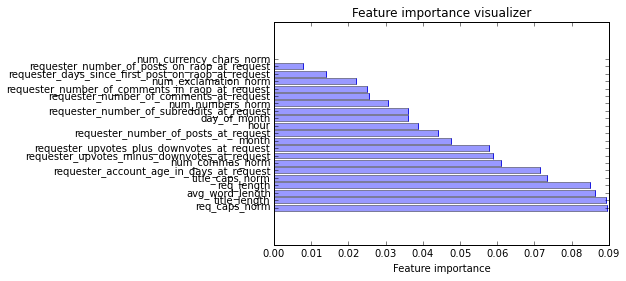

In [41]:
#Run test of decision tree
decision_tree_model = DecisionTreeModel(master_data.getTrain(),master_data.getDev())
decision_tree_model.run_model()
print decision_tree_model.test()

decision_tree_model.extractFeatureImportance()
featureImportanceVisualizer(decision_tree_model)


In [26]:
class RandomForestModel(Model):
    '''
    Random Forest   
    '''
    def __init__(self,dfFit,dfPredict):
        Model.__init__(self,dfFit,dfPredict)
        self.classifier = RandomForestClassifier
        #how to process data
        self.fit_data,self.feature_names = fe.augNumericFeatures(self.dfFit)
        self.predict_data,_ = fe.augNumericFeatures(self.dfPredict)
    
    def run_model(self):
        #predict
        self.prediction = self.classify()  
    
    def classify(self):
        self.c = RandomForestClassifier(n_estimators=100,
                                    criterion='entropy')#,
                                    #max_features=10) #criterion can be 'gini' or 'entropy'
        self.c.fit(self.fit_data, self.fit_labels)
        return self.c.predict(self.predict_data) 
    
    def extractFeatureImportance(self):
        stdDev = np.std([dTree.feature_importances_ for dTree in self.c],axis=0)
        importances = self.c.feature_importances_
        ind = np.argsort(-importances)
        importances_sorted = importances[ind]
        importances_names = np.asarray(self.feature_names)[ind]
        stdDev_sorted = stdDev[ind]
        return importances_names,importances_sorted,stdDev_sorted
        
    

In [20]:
#RF for cross val and GS purposes
rf_model = RandomForestModel(master_data.getTrain(),master_data.getDev())

#Run grid search
params = {'n_estimators' : range(10,200,10)}
gs = rf_model.gridSearch(params)


{'n_estimators': 170}


In [21]:
#now cross val on best GS values
rf_model.crossVal({'n_estimators': 170})


Mean AUC: 0.617565202982


array([ 0.60221663,  0.6131904 ,  0.60648174,  0.64837203])

In [31]:
class EnsembleForest(RandomForestModel):
    '''
    RF that incorporates text data via votes of another classifier
    BROKEN: Because ensemble1 init_test and doesn't ever init_final, you can't use this model's 
    init_final or finalize.
    '''
    def __init__(self,dfFit,dfPredict):
        RandomForestModel.__init__(self,dfFit,dfPredict)
        #how to process data
        self.ensembleFeatures()
    
    def ensembleFeatures(self):
        '''
        creates self.fit_data, self.predict_data and self.feature_names
        '''
        ###FIT features
        f1,l1 = fe.augNumericFeatures(self.dfFit) 
        #add outputs of tuned baseline classifier
        lvl1class = BaselineTuned(self.dfFit,self.dfFit) #note predicts it's own train data!
        lvl1class.run_model()
        f2 = lvl1class.getPrediction()          
        l2 = ['lvl1classifier']
        self.fit_data = np.column_stack((f1,f2))
        ###FEATURE Labels
        self.feature_names = l1+l2
        ###PREDICT features
        f1,_ = fe.augNumericFeatures(self.dfPredict)
        lvl1class = BaselineTuned(self.dfFit,self.dfPredict) #this time predict on predict data
        lvl1class.run_model()
        f2 = lvl1class.getPrediction()          
        self.predict_data = np.column_stack((f1,f2))
   

In [43]:
class EnsembleTree(DecisionTreeModel):
    '''
    RF that incorporates text data via votes of another classifier
    BROKEN: Because ensemble1 init_test and doesn't ever init_final, you can't use this model's 
    init_final or finalize.
    '''
    def __init__(self,dfFit,dfPredict):
        DecisionTreeModel.__init__(self,dfFit,dfPredict)
        #how to process data
        self.ensembleFeatures()
    
    def ensembleFeatures(self):
        '''
        creates self.fit_data, self.predict_data and self.feature_names
        '''
        ###FIT features
        f1,l1 = fe.augNumericFeatures(self.dfFit) 
        #add outputs of tuned baseline classifier
        lvl1class = BaselineTuned(self.dfFit,self.dfFit) #note predicts it's own train data!
        lvl1class.run_model()
        f2 = lvl1class.getPrediction()          
        l2 = ['lvl1classifier']
        self.fit_data = np.column_stack((f1,f2))
        ###FEATURE Labels
        self.feature_names = l1+l2
        ###PREDICT features
        f1,_ = fe.augNumericFeatures(self.dfPredict)
        lvl1class = BaselineTuned(self.dfFit,self.dfPredict) #this time predict on predict data
        lvl1class.run_model()
        f2 = lvl1class.getPrediction()          
        self.predict_data = np.column_stack((f1,f2))

In [10]:
class EnsembleNB(NumericModel):
    '''
    NB that incorporates text data via votes of another classifier
    BROKEN: Because ensemble1 init_test and doesn't ever init_final, you can't use this model's 
    init_final or finalize.
    '''
    def ensemble1(self):
        e = Baseline()
        e.init_test()
        e.run_model()
        #get dev data prediction
        devPrediction = e.getPrediction()
        #now reset internal data so we can get test data prediction
        e.mod_for_ensemble()
        e.run_model()
        testPrediction = e.getPrediction()
        return testPrediction, devPrediction
    
    def init_final(self):
        raise NotImplementedError('Low level ensemble is hard coded to init_test at the moment')
    
    def run_model(self):
        train1 = fe.augNumericFeatures(self.train_data)
        test1 = fe.augNumericFeatures(self.test_data)
        train2,test2 = self.ensemble1()
        train = np.column_stack((train1,train2))
        test = np.column_stack((test1,test2))
        print train.shape
        print train1.shape
        print train2.shape
        print test.shape
        print test1.shape
        print test2.shape
        #predict
        self.prediction = self.classify(train,test)  

In [11]:
class StackedRegression():
    '''
    Stacking with logistic regression.
    Makes a linear combination of outputs of other models
    http://link.springer.com/article/10.1007%2FBF00117832
    '''
    raise NotImplementedError("Need a 28 hour day")

NotImplementedError: Need a 28 hour day

In [11]:
'''
TUTORIAL: This cell shows how the dataframes above get accessed and turned into usable numpy arrays
'''

###Task: Extracting message text AND title text into a feature vector:
#first find name of column by printing out the list of names
trainColumnNames = master_data.getTrainColumnNames()
pprint(trainColumnNames) #looks like we want 'request_text_edit_aware' and 'request_title'
#find which number this is or manually type column name
print '\n'
print trainColumnNames[7]
print trainColumnNames[8]

#two ways to get data we want:
print '\n'
X_train = master_data.getTrain()[['request_text_edit_aware','request_title']] #method 1
X_train = master_data.getTrain()[[trainColumnNames[7],trainColumnNames[8]]] #method 2
print X_train.head() #.head() just prints the first 5 rows

#The above X_train is still a pandas dataframe. Converting to numpy array for sklearn is as simple as:
print '\n'
X_train = X_train.values
print type(X_train)
print X_train.shape

#In summary (quick way):
X_train = master_data.getTrain()[['request_text_edit_aware','request_title']].values 

###Task: Join 2 numpy arrays horizontally (e.g. merge train and dev for final submission)
train_data = master_data.getTrain()['request_text_edit_aware'].values
dev_data = master_data.getDev()['request_text_edit_aware'].values
merged_data = np.concatenate((train_data,dev_data),axis=0)
print '\n'
print train_data.shape,' ',dev_data.shape,' ',merged_data.shape

###Task: Join 2 numpy arrays vertically (e.g. add a bunch of features)
train_data1 = master_data.getTrain()['request_text_edit_aware'].values
#now we want more features... say from some feature engineering process
train_data2 = master_data.getTrain()['request_title'].values
train_data_merged = np.column_stack((train_data1,train_data2)) #<---- where the action is at!
print '\n'
print train_data1.shape,' ',train_data2.shape,' ',train_data_merged.shape

###Task: Use the Classes
'''
To use:
1) instantiate your model class
2) initialize it as either test or final
3) run it and either test or finalize it

'''

[u'giver_username_if_known',
 u'number_of_downvotes_of_request_at_retrieval',
 u'number_of_upvotes_of_request_at_retrieval',
 u'post_was_edited',
 u'request_id',
 u'request_number_of_comments_at_retrieval',
 u'request_text',
 u'request_text_edit_aware',
 u'request_title',
 u'requester_account_age_in_days_at_request',
 u'requester_account_age_in_days_at_retrieval',
 u'requester_days_since_first_post_on_raop_at_request',
 u'requester_days_since_first_post_on_raop_at_retrieval',
 u'requester_number_of_comments_at_request',
 u'requester_number_of_comments_at_retrieval',
 u'requester_number_of_comments_in_raop_at_request',
 u'requester_number_of_comments_in_raop_at_retrieval',
 u'requester_number_of_posts_at_request',
 u'requester_number_of_posts_at_retrieval',
 u'requester_number_of_posts_on_raop_at_request',
 u'requester_number_of_posts_on_raop_at_retrieval',
 u'requester_number_of_subreddits_at_request',
 u'requester_received_pizza',
 u'requester_subreddits_at_request',
 u'requester_upvo

'\nTo use:\n1) instantiate your model class\n2) initialize it as either test or final\n3) run it and either test or finalize it\n\n'

In [13]:
# Run test of baseline
baseline_model = Baseline(master_data.getTrain(),master_data.getDev())
baseline_model.run_model()
print baseline_model.test()

0.55160457863


In [100]:
# Run final of baseline
baseline_model = Baseline(master_data.getTrainFull(),master_data.getTest())
baseline_model.run_model()
baseline_model.writeSubmission('test_finalize.csv')

[0 0 0 ..., 0 1 0]


In [15]:
# Run test of BaselineTuned
tuned = BaselineTuned(master_data.getTrain(),master_data.getDev())
tuned.run_model()
print 'test result: ', tuned.test()

crossVal = tuned.crossVal({'penalty': 'l1', 'C': 0.092})

test result:  0.502081915045
Mean AUC: 0.583418398092


In [16]:
# Run final of BaselineTuned
tuned = Baseline(master_data.getTrainFull(),master_data.getTest())
tuned.run_model()
tuned.writeSubmission('test_finalize.csv')

[0 0 0 ..., 0 1 0]


In [130]:
#Run NumericModel
numeric_model = NumericModel(master_data.getTrain(),master_data.getDev())
numeric_model.run_model()
print numeric_model.test()

0.530933194011


In [131]:
#Run test of decision tree
decision_tree_model = DecisionTreeModel(master_data.getTrain(),master_data.getDev())
decision_tree_model.run_model()
print decision_tree_model.test()

0.524998812596


In [20]:
#Run test of random forest
rf_model = RandomForestModel(master_data.getTrain(),master_data.getDev())
rf_model.run_model()
print rf_model.test()


0.51822005499


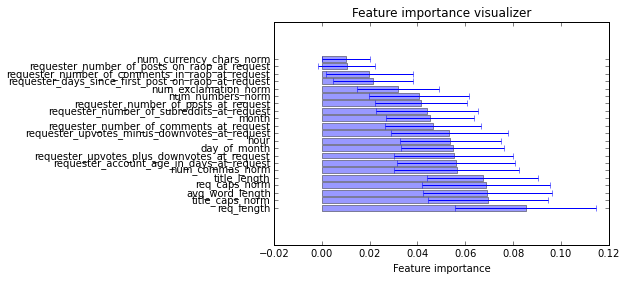

In [21]:
#Run feature importance vis using random forest
featureImportanceVisualizer(rf_model)

0.51427787365


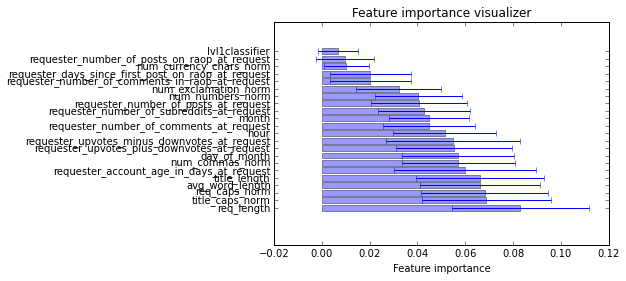

In [35]:
#Run test of EnsembleForest
ef_model = EnsembleForest(master_data.getTrain(),master_data.getDev())
ef_model.run_model()
print ef_model.test()

#Run feature importance vis using random forest
featureImportanceVisualizer(ef_model)

0.523573927774
(22L,)
(22L,)


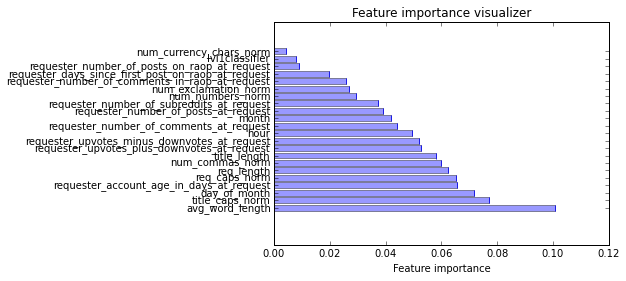

In [45]:
#Run test of EnsembleTree
et_model = EnsembleTree(master_data.getTrain(),master_data.getDev())
et_model.run_model()
print et_model.test()

#Run feature importance vis using random forest
featureImportanceVisualizer(et_model)

In [285]:
#Run test of EnsembleNB
enb_model = EnsembleForest()
enb_model.init_test()
enb_model.run_model()
print enb_model.test()


(3030L, 22L)
(3030L, 21L)
(3030L,)
(1010L, 22L)
(1010L, 21L)
(1010L,)
0.550947548407


In [68]:
"""
EXPERIMENTS Cell
Cell for all experiments that don't fit neatly elsewhere.
"""
    
def colNamePrint():
    '''
    Just print out TEST column names w indices for ref.
    '''
    c = master_data.getTestColumnNames()
    for i,n in enumerate(c):
        print i, '_',n
    #END

def correlationVis(df):
    pass

def tuneBaseline():
    '''
    Conducts a GridSearch of LR params
    Visualizes result - useful to discern if result is from overfitting or not
    WARNING: Takes several minutes!
    '''

    #initiate a Baseline obj
    baseline_model = Baseline(master_data.getTrain(),master_data.getDev())

    ####Run grid search
    params = {'penalty': ['l1','l2'],'C':np.logspace(-2,2,30)}
    gs = baseline_model.gridSearch(params)

    ####Print and plot results
    scores = gs.grid_scores_

    l1_means = []
    l2_means = []
    C = []

    for i in range(len(gs.grid_scores_)):
        #append to relevant means vector
        if scores[i][0]['penalty'] == 'l1':
            l1_means.append(scores[i][1])
            #append C vector
            C.append(scores[i][0]['C'])
        elif scores[i][0]['penalty'] == 'l2':
            l2_means.append(scores[i][1])
        else:
            raise ValueError("function can't handle given params")

    #plot   
    plt.plot(C,l1_means,C,l2_means,'r')
    #plt.plot()
    plt.semilogx()
    plt.legend(['l1 penalty','l2 penalty'],'best')
    plt.show()



{'penalty': 'l1', 'C': 0.092367085718738612}


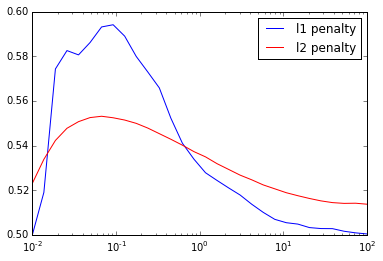

In [69]:
tuneBaseline()

In [34]:
"""
VISUALISATION Cell
"""

def timeVisualizer():
    '''
    Visualize time related trends. Does RAOP get more or less generous over time? 
    Certain times of day? Certain days of week?
    '''
    raise NotImplementedError

def featureImportanceVisualizer(fitted_model):
    '''
    Takes a fitted model with a 'extractFeatureImportance' method
    plots bar graph of features
    see http://matplotlib.org/examples/lines_bars_and_markers/barh_demo.html for plotting example
    '''
    labs,means,std_devs = fitted_model.extractFeatureImportance()
    err = std_devs*1.96 #95th percentile confidence interval
    
    #plot results
    y_pos = np.arange(labs.shape[0])
    plt.barh(y_pos, means, xerr=err, align='center', alpha=0.4)
    plt.yticks(y_pos,labs)
    plt.xlabel('Feature importance')
    plt.title('Feature importance visualizer')
    
    plt.show()
    
    
    